In [30]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("camnugent/california-housing-prices")

print("Path to dataset files:", path)


Using Colab cache for faster access to the 'california-housing-prices' dataset.
Path to dataset files: /kaggle/input/california-housing-prices


# **Step 1: Load the dataset from the Kaggle path**



In [31]:
import pandas as pd
import os

csv_file = os.path.join(path, "housing.csv")
df = pd.read_csv(csv_file)

df.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# **Step 2: Do EDA (Heatmap + Scatter)**

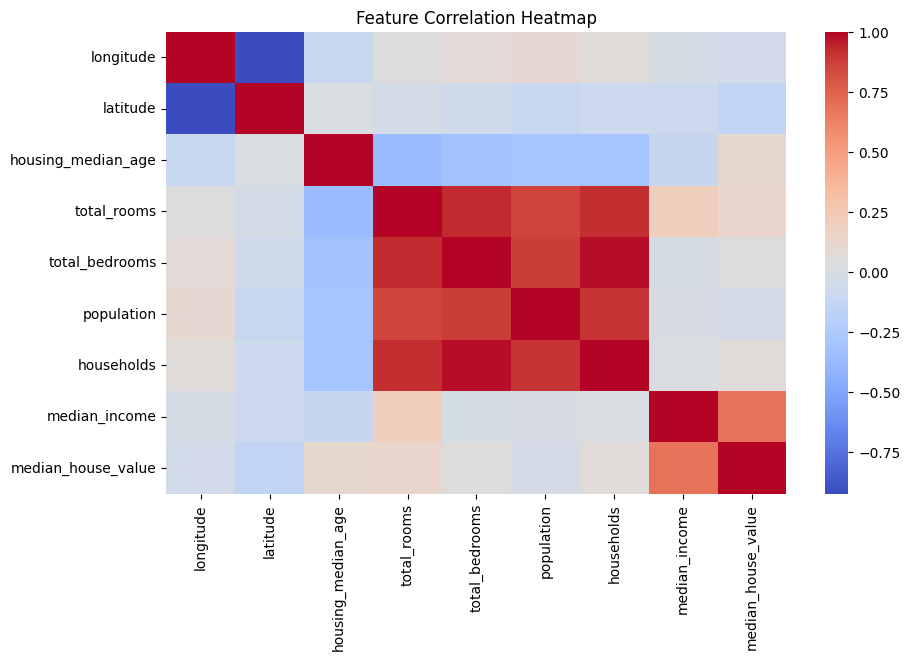

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


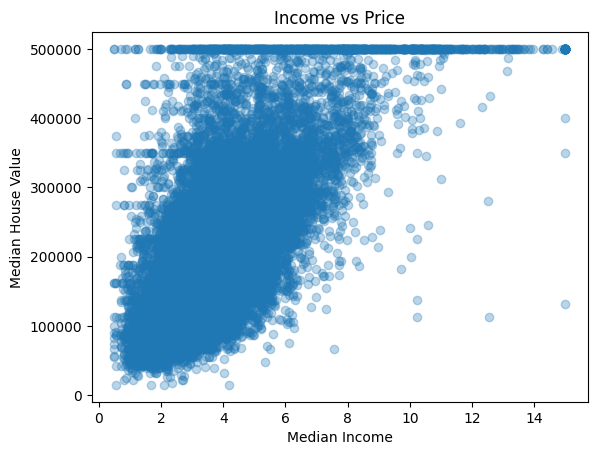

In [34]:
plt.scatter(df["median_income"], df["median_house_value"], alpha=0.3)
plt.xlabel("Median Income")
plt.ylabel("Median House Value")
plt.title("Income vs Price")
plt.show()

# **Step 3: Simple Linear Regression (median_income → price)**

Simple LR trained:
w (slope): 41798.085058930716
b (bias) : 45065.43497007328


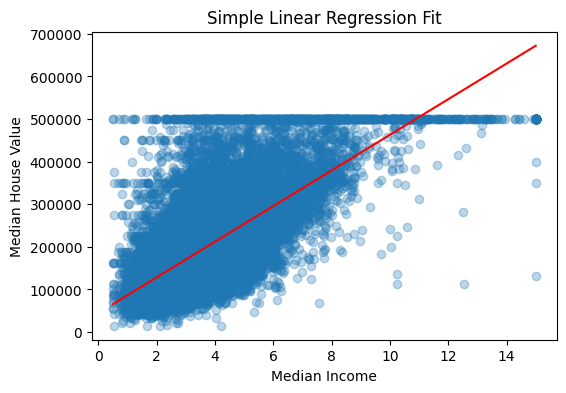

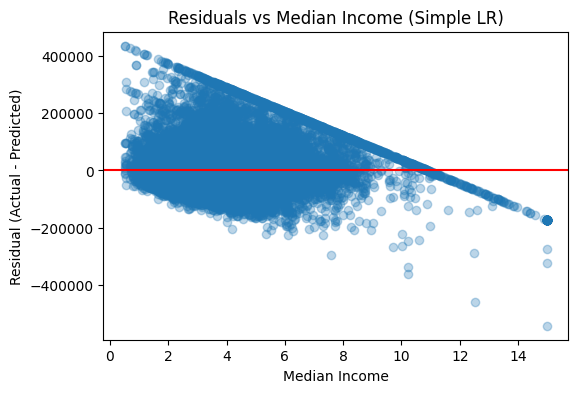

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# --- Step 3: Simple Linear Regression (from scratch) ---
X = df["median_income"].values.astype(float)
y = df["median_house_value"].values.astype(float)

def predict(x, w, b):
    return w * x + b

# Train with gradient descent
w, b = 0.0, 0.0
lr = 0.01
epochs = 2000

for _ in range(epochs):
    y_hat = predict(X, w, b)
    dw = -2 * np.mean(X * (y - y_hat))
    db = -2 * np.mean(y - y_hat)
    w -= lr * dw
    b -= lr * db

print("Simple LR trained:")
print("w (slope):", w)
print("b (bias) :", b)

# Plot data + fitted line
plt.figure(figsize=(6,4))
plt.scatter(X, y, alpha=0.3)
x_line = np.linspace(X.min(), X.max(), 200)
plt.plot(x_line, predict(x_line, w, b), color="red")
plt.xlabel("Median Income")
plt.ylabel("Median House Value")
plt.title("Simple Linear Regression Fit")
plt.show()

# Residual plot
residuals = y - predict(X, w, b)
plt.figure(figsize=(6,4))
plt.scatter(X, residuals, alpha=0.3)
plt.axhline(0, color="red")
plt.xlabel("Median Income")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Median Income (Simple LR)")
plt.show()


# **Step 4: Log-transform target + re-train + plot residuals**

Log-target LR trained:
w (slope): 0.19856290564637516
b (bias) : 11.315154964845151


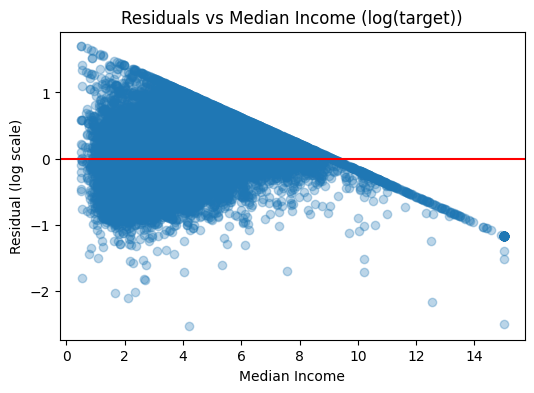


First 5 predicted vs actual (dollars):
pred=$428,578  actual=$452,600
pred=$426,558  actual=$358,500
pred=$346,696  actual=$352,100
pred=$251,616  actual=$341,300
pred=$176,110  actual=$342,200


In [36]:
import numpy as np
import matplotlib.pyplot as plt

# --- Step 4: Fix issues using log(target) ---
X = df["median_income"].values.astype(float)
y = df["median_house_value"].values.astype(float)

y_log = np.log1p(y)  # log(1 + y)

def predict(x, w, b):
    return w * x + b

# Train on log target
w, b = 0.0, 0.0
lr = 0.01
epochs = 2000

for _ in range(epochs):
    y_hat_log = predict(X, w, b)
    dw = -2 * np.mean(X * (y_log - y_hat_log))
    db = -2 * np.mean(y_log - y_hat_log)
    w -= lr * dw
    b -= lr * db

print("Log-target LR trained:")
print("w (slope):", w)
print("b (bias) :", b)

# Residual plot on log scale
residuals_log = y_log - predict(X, w, b)

plt.figure(figsize=(6,4))
plt.scatter(X, residuals_log, alpha=0.3)
plt.axhline(0, color="red")
plt.xlabel("Median Income")
plt.ylabel("Residual (log scale)")
plt.title("Residuals vs Median Income (log(target))")
plt.show()

# OPTIONAL: show a few predictions back in dollars
y_pred_dollars = np.expm1(predict(X, w, b))
print("\nFirst 5 predicted vs actual (dollars):")
for p, a in zip(y_pred_dollars[:5], y[:5]):
    print(f"pred=${p:,.0f}  actual=${a:,.0f}")


# **Step 5: Engineer Better Features**

In [37]:
df["total_bedrooms"] = df["total_bedrooms"].fillna(df["total_bedrooms"].median())

df["rooms_per_household"] = df["total_rooms"] / df["households"]
df["bedrooms_per_household"] = df["total_bedrooms"] / df["households"]
df["population_per_household"] = df["population"] / df["households"]

df = df.replace([np.inf, -np.inf], np.nan).dropna()


# **Step 6: Build Multiple Linear Regression (from scratch)**

In [38]:
import numpy as np

features = [
    "median_income",
    "latitude",
    "longitude",
    "housing_median_age",
    "rooms_per_household",
    "bedrooms_per_household",
    "population_per_household"
]

X = df[features].values
y = np.log1p(df["median_house_value"].values)

# Scale features
mean = X.mean(axis=0)
std = X.std(axis=0)
X = (X - mean) / std

w = np.zeros(X.shape[1])
b = 0
lr = 0.05
epochs = 3000

for _ in range(epochs):
    y_hat = X @ w + b
    error = y_hat - y

    dw = (2/len(y)) * (X.T @ error)
    db = (2/len(y)) * error.sum()

    w -= lr * dw
    b -= lr * db

print("Trained weights:", w)
print("Trained bias:", b)


Trained weights: [ 0.3236506  -0.63039035 -0.58898192  0.02646119 -0.00822102  0.04005064
 -0.01613973]
Trained bias: 12.08489084500998


# **Step 7: Improve Using Ridge & Lasso (sklearn)**

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

X = df[features]
y = np.log1p(df["median_house_value"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=0.001)

ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

ridge_pred = ridge.predict(X_test)
lasso_pred = lasso.predict(X_test)

print("Ridge RMSE:", np.sqrt(mean_squared_error(y_test, ridge_pred)))
print("Ridge R²:", r2_score(y_test, ridge_pred))

print("Lasso RMSE:", np.sqrt(mean_squared_error(y_test, lasso_pred)))
print("Lasso R²:", r2_score(y_test, lasso_pred))


Ridge RMSE: 0.39331850410924035
Ridge R²: 0.5233583790604301
Lasso RMSE: 0.3874143111688012
Lasso R²: 0.5375609242629893


# **Step 8: Plot Residuals**

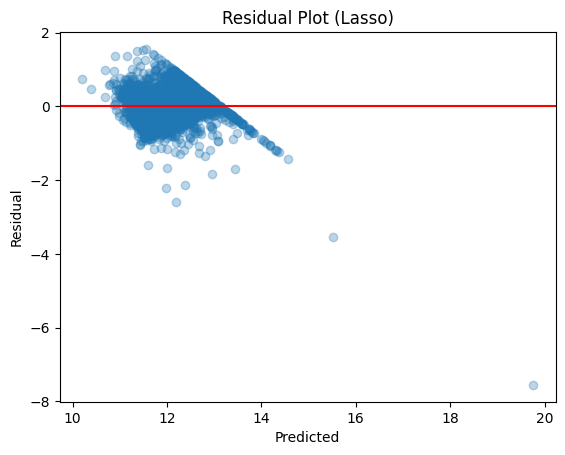

In [40]:
residuals = y_test - lasso_pred

plt.scatter(lasso_pred, residuals, alpha=0.3)
plt.axhline(0, color="red")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residual Plot (Lasso)")
plt.show()
